## A simple 1 -dimensional example to infer hyper parameters with selection effects:

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

### True value of hyper parameter

In [15]:
mu_lambda_T = 4.3 # in meters
sigma_lambda = 2 # in meters
x_max = 5 # in meters

### Generating true positions of speakers that will be playing:

In [165]:
N = 1000
x_T = np.random.normal(mu_lambda_T, sigma_lambda, N)

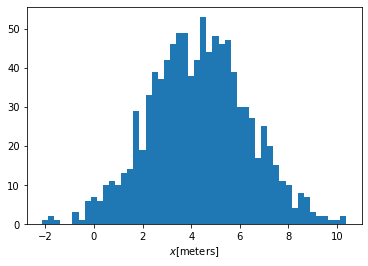

In [166]:
plt.hist(x_T, bins=50)
plt.xlabel('$x$[meters]')
plt.show()

### Generating noise (with zero mean and unit variance) and data:

In [167]:
noise = np.random.normal(0, 1, N)
data = x_T + noise

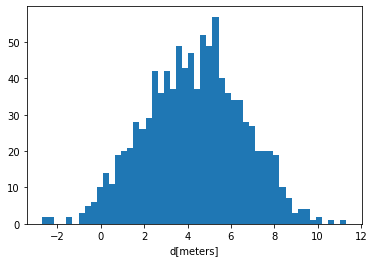

In [168]:
plt.hist(data, bins=50)
plt.xlabel('d[meters]')
plt.show()

#### Apply the selection effects i.e. only retain the data that satisfy the detection criteria: $d_i < x_{\mathrm{max}}$

In [169]:
selection_idx = data < x_max
xi = data[selection_idx]
N_tr = len(xi)
N_tr

608

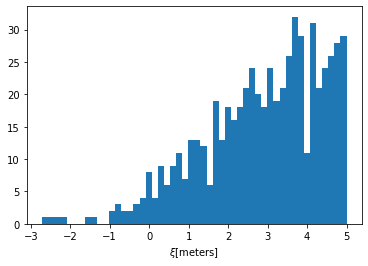

In [170]:
plt.hist(xi, bins=50)
plt.xlabel(r"$\xi$[meters]")
plt.show()

### Estimating selection effects:

$$ \alpha(\mu_\lambda) = \int dx \pi(x|\mu_\lambda) p(\rho_{\uparrow}|x)$$

In [171]:
def prior_x(x, mu, sigma):
    return np.exp(-(x - mu)**2 / (2*sigma**2)) / (np.sqrt(2 * np.pi * sigma**2))

In [215]:
mu_lambda = np.linspace(0, 10, 100)
sig_lambda = 2

In [216]:
def selection_function(mu_lamb, sig_lamb, x_max):
    
    x = np.linspace(-10, 10, 1000)
    detectability_function = (1/2) * ( 1 + erf((x_max - x) / np.sqrt(2)))
    
    alpha_lambda = []
    for mu in mu_lamb:
        prior_function = prior_x(x, mu, sig_lamb)
        alpha_lambda.append(np.trapz(detectability_function * prior_function, x))
        
    return np.array(alpha_lambda)

In [217]:
alpha_mu_lambda = selection_function(mu_lambda, sig_lambda, x_max)
#alpha_mu_lambda

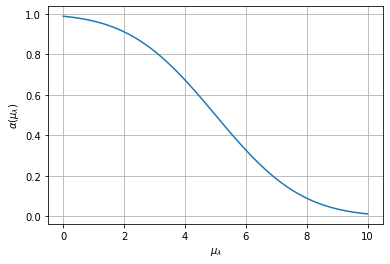

In [218]:
plt.plot(mu_lambda, alpha_mu_lambda)
plt.xlabel(r"$\mu_\lambda$")
plt.ylabel(r"$\alpha(\mu_\lambda)$")
plt.grid()

### Analytical hyper-posterior:

In [262]:
def hyper_posterior(mu_lambda, sig_lambda, data, selection_function):
    
    N_trigger = len(data)
    log_posterior = []
    
    for mu, alpha_lambda in zip(mu_lambda, selection_function):
        exponent_argument = 0.0
        for d in data:
            exponent_argument += -(d - mu)**2 / (2 * (1 + sig_lambda**2)) 
            
        log_posterior.append(exponent_argument - N_trigger*np.log(alpha_lambda))
    
    log_posterior = np.array(log_posterior)
    #log_posterior = np.exp(log_posterior)#/max(abs(log_posterior))
    return np.array(np.exp(log_posterior))

### Estimating hyper posterior using detected data and selection effects:

In [278]:
mu_lambda_posterior = hyper_posterior(mu_lambda, sig_lambda, xi, alpha_mu_lambda)

Text(0.5, 1.0, '$x_{max} = 5, \\mu_\\lambda^T = 4.3, \\sigma_\\lambda = 2$')

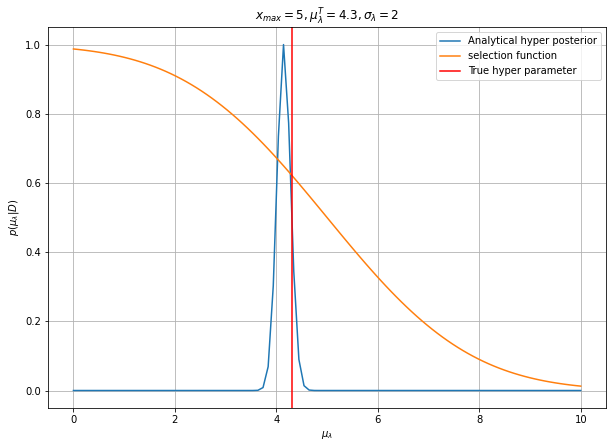

In [279]:
plt.figure(figsize=(10,7))
plt.plot(mu_lambda, mu_lambda_posterior/max(mu_lambda_posterior), label="Analytical hyper posterior")
plt.plot(mu_lambda, alpha_mu_lambda, label="selection function")
plt.axvline(x=mu_lambda_T, c='r', label="True hyper parameter")
plt.xlabel("$\mu_\lambda$")
plt.ylabel("$ p(\mu_\lambda|D)$")
plt.legend(loc='best')
plt.grid()
plt.title("$x_{max} = 5, \mu_\lambda^T = 4.3, \sigma_\lambda = 2$")